Build a neural network which is separated in two blocks:
* A common set of "base" features
* One feature with a special dependence

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [57]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split

## Build artificial dataset with one monotonic variable

We will build a classification problem where the dependence on one of the variables is monotonic

In [53]:
X, y = make_classification(n_samples=3000, n_features=9, n_informative=9, n_redundant=0, n_repeated=0,
                          random_state=2)

X = pd.DataFrame(X, columns=[f'col_{i}' for i in range(9)])
y = pd.Series(y)

Artificially introduce a tenth feature based on the results of a logistic regression applied to the model

In [54]:
lr = LogisticRegression(C=1e-3)
lr.fit(X, y)
predictions = lr.predict_proba(X)[:,1]
roc_auc_score(y, predictions)

0.9194776496188416

In [55]:
# add noise to avoid extreme overfitting
np.random.seed(3)
new_feat = predictions + 0.4*np.random.randn(*y.shape)
roc_auc_score(y, new_feat)

0.7369243514620548

In [56]:
X['delta'] = new_feat

## Create neural network

From https://stackoverflow.com/questions/64116920/how-to-input-single-variable-at-the-last-layer-in-keras

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [68]:
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam

In [62]:
# separate into delta vs. other columns
feature_x = X_train.drop(columns='delta')
single_feature_x = X_train[['delta']]

input_x = Input(shape=feature_x.shape[1], name='feature_input')
single_input_x = Input(shape=single_feature_x.shape[1], name='single_input')

In [159]:
# build network for the other features
x1 = Dense(4, activation='relu')(input_x)
x2 = Dense(4, activation='relu')(x1)

# you can keep increasing here, using the functional API

# concatenate
concat_feat = Concatenate(axis=-1, name='concat_fc')([x2, single_input_x])

outputs = Dense(1, activation='sigmoid')(concat_feat)

model = Model(inputs=[input_x, single_input_x], outputs=outputs)
model.compile(loss='binary_crossentropy',
              metrics=[keras.metrics.AUC()],
              optimizer=Adam(lr=0.001))

model.fit({'feature_input': feature_x,
           'single_input': single_feature_x},
          y_train,
          epochs=100,
          batch_size=256,
          verbose=0);

## Predicting on new data; compare to baseline

Baseline logistic regression

In [160]:
baseline = LogisticRegression()
baseline.fit(X_train, y_train)
roc_auc_score(y_test, baseline.predict_proba(X_test)[:,1])

0.9244057381098224

Neural network

In [234]:
y_probs = model.predict([X_test.drop('delta', axis=1), X_test[['delta']]])
y_probs = y_probs.reshape(len(y_probs),)

In [162]:
roc_auc_score(y_test, y_probs)

0.9463781145646031

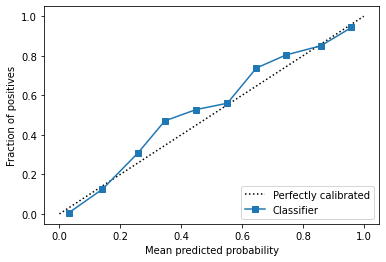

In [232]:
CalibrationDisplay.from_predictions(y_test, y_probs, n_bins=10)

## Build simulator

In [228]:
i = 1
person = X_test.iloc[i]
his_delta = person['delta']
print('Real: ', y_test.iloc[i])
print('Predicted: ', y_probs[i])

Real:  0
Predicted:  0.031107575


In [229]:
simulated_deltas = np.arange(-10, 40, 0.1)
X_sim = pd.concat([pd.DataFrame(person).T]*len(simulated_deltas))
X_sim['delta'] = simulated_deltas

In [230]:
y_sim = model.predict([X_sim.drop('delta', axis=1), X_sim[['delta']]])

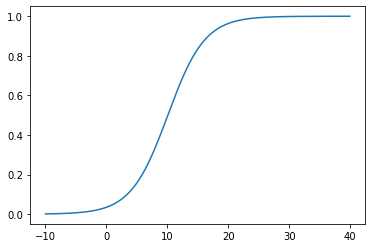

In [231]:
plt.plot(simulated_deltas, y_sim)

Simulator works

### Sklearn API

In [252]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow import keras
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam

class SingleMonotonicFeatureNN(BaseEstimator, ClassifierMixin):
    
    def __init__(self,
                 single_feature: str):
        self.single_feature = single_feature
        self.model = None
        
   
    def fit(self, X: pd.DataFrame, y: pd.Series,
            epochs=100,
            batch_size=256,
            verbose=0,
            learning_rate=0.001):
        
        feature_x = X.drop(columns=self.single_feature)
        single_feature_x = X[[self.single_feature]]
        
        self._build_model(feature_x, single_feature_x)
        
        self.model.compile(loss='binary_crossentropy',
                           metrics=[keras.metrics.AUC()],
                           optimizer=Adam(lr=learning_rate))
        
        self.model.fit({'feature_input': feature_x,
                        'single_input': single_feature_x},
                        y,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose);
        return self

    def _build_model(self, feature_x, single_feature_x):

        input_x = Input(shape=feature_x.shape[1], name='feature_input')
        single_input_x = Input(shape=single_feature_x.shape[1], name='single_input')
        
        # this is where you edit the model
        x1 = Dense(4, activation='relu')(input_x)
        x2 = Dense(4, activation='relu')(x1)

        # concatenate
        concat_feat = Concatenate(axis=-1, name='concat_fc')([x2, single_input_x])
        outputs = Dense(1, activation='sigmoid')(concat_feat)

        self.model = Model(inputs=[input_x, single_input_x], outputs=outputs)
    
    def predict_proba(self, X):
        y_probs = self.model.predict([X.drop(self.single_feature, axis=1), X[[self.single_feature]]])
        y_probs = y_probs.reshape(len(y_probs),)
        
        sklearn_probs = np.array([1-y_probs, y_probs]).T
        return sklearn_probs
    
    def predict(self, X):
        raise Exception("Never use .predict! Only .predict_proba :)")

In [253]:
model = SingleMonotonicFeatureNN(single_feature='delta')

In [258]:
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_probs)

0.9689778497895631